# Compare the 2D and 3D codes
Here, we use a simple set-up of a short piece of casing with a current source aligned along its axis. We solve in 3D and using the cyl symmetric solution and compare. 

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0

import discretize
from discretize import utils
from SimPEG.EM import FDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

import casingSimulations
%matplotlib inline

In [2]:
sigma_back = 1e-1 # wholespace

model = casingSimulations.model.CasingInWholespace(
    casing_l = 10.,
    src_a = np.r_[0., 0., -9.],
    src_b = np.r_[0., 0., -1.],
    freqs = np.r_[0.1, 1., 2.],
    sigma_back = sigma_back, # wholespace
    sigma_casing = 1e6,
    sigma_inside = 1, 
    mur_casing=100,
)


In [3]:
model.serialize()

{u'__class__': 'CasingInWholespace',
 'casing_d': 0.1,
 'casing_l': 10.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'.',
 'filename': u'ModelParameters.json',
 'freqs': [0.1, 1.0, 2.0],
 'mur_back': 1.0,
 'mur_casing': 100.0,
 'sigma_back': 0.1,
 'sigma_casing': 1000000.0,
 'sigma_inside': 1.0,
 'src_a': [0.0, 0.0, -9.0],
 'src_b': [0.0, 0.0, -1.0],
 'version': u'0.0.5'}

In [4]:
npadx, npadz = 11, 26
dx2 = 500. 

mesh2DGen = casingSimulations.mesh.CasingMeshGenerator(
    modelParameters=model, csx1=model.casing_t/4, csz=0.25, npadx=npadx, npadz=npadz, domain_x=dx2
)
mesh3DGen = casingSimulations.mesh.CasingMeshGenerator(
    modelParameters=model, csx1=model.casing_t/4, csz=0.25, hy=np.ones(4)/4*2*np.pi, npadx=npadx, npadz=npadz, domain_x=dx2
)

mesh2D = mesh2DGen.mesh
mesh3D = mesh3DGen.mesh

In [5]:
print(mesh2D.nC, mesh3D.nC)

(9180, 36720)


In [6]:
model.skin_depth()

array([ 5032.92121045,  1591.54943092,  1125.3953952 ])

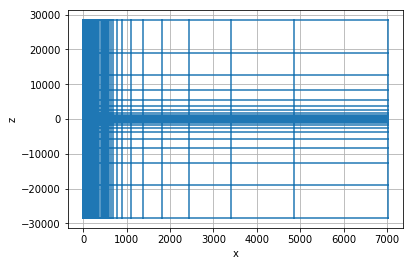

In [7]:
mesh2D.plotGrid()

In [8]:
def getSrcWire(mesh):
    wire = np.zeros(mesh.vnF[2])

    xfaces = mesh.gridFz[:,0] < mesh.hx.min()
    zfaces = (mesh.gridFz[:,2] > model.src_a[2]) & (mesh.gridFz[:,2] < model.src_b[2])
    wire[xfaces & zfaces] = 1
    
    return np.hstack([np.zeros(mesh.nFx), np.zeros(mesh.nFy), wire]) 

In [9]:
# specify current density on the faces (wire source through center of well) - 2D mesh
wire2D = getSrcWire(mesh2D)
wire3D = getSrcWire(mesh3D)

In [10]:
srcList2D = [FDEM.Src.RawVec_e(s_e=wire2D, freq=freq, rxList=[]) for freq in model.freqs]
srcList3D = [FDEM.Src.RawVec_e(s_e=wire3D, freq=freq, rxList=[]) for freq in model.freqs] 

In [11]:
physprops2D = casingSimulations.model.PhysicalProperties(modelParameters=model, meshGenerator=mesh2DGen)
physprops3D = casingSimulations.model.PhysicalProperties(modelParameters=model, meshGenerator=mesh3DGen)

[(-20.0, 10.0), (-20.0, 10.0)]

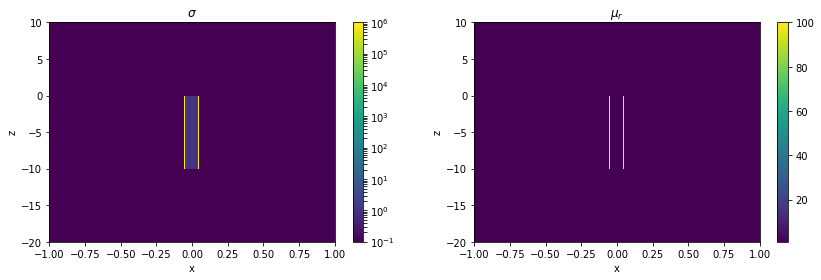

In [12]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-20, 10.]

ax = physprops2D.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

[(-20.0, 10.0), (-20.0, 10.0)]

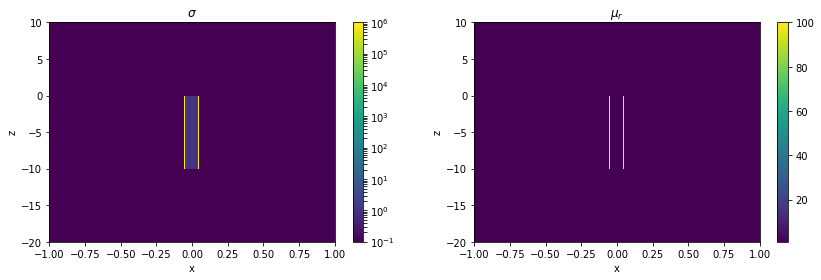

In [13]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-20, 10.]

ax = physprops3D.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [14]:
prb2D = FDEM.Problem3D_h(mesh2D, sigmaMap=physprops2D.wires.sigma, muMap=physprops2D.wires.mu, Solver=Pardiso)
prb3D = FDEM.Problem3D_h(mesh3D, sigmaMap=physprops3D.wires.sigma, muMap=physprops3D.wires.mu, Solver=Pardiso)

In [15]:
survey2D = FDEM.Survey(srcList2D)
survey3D = FDEM.Survey(srcList3D)

In [16]:
prb2D.pair(survey2D)
prb3D.pair(survey3D)

In [17]:
%%time

fields2D = prb2D.fields(physprops2D.model)

CPU times: user 430 ms, sys: 35.9 ms, total: 466 ms
Wall time: 358 ms


In [18]:
%%time

fields3D = prb3D.fields(physprops3D.model)

CPU times: user 29.4 s, sys: 2.22 s, total: 31.6 s
Wall time: 22 s


In [19]:
freqind = 0
print('getting j at {}Hz'.format(model.freqs[freqind]))

j2D = fields2D[srcList2D[0], 'j']
j3D = fields3D[srcList3D[0], 'j']

getting j at 0.1Hz


In [20]:
def getj3Dplot(j3D, theta_ind=0):
    j3D_x = j3D[:mesh3D.nFx].reshape(mesh3D.vnFx, order='F')
    j3D_z = j3D[mesh3D.vnF[:2].sum():].reshape(mesh3D.vnFz, order='F')
    
    j3Dplt = np.vstack([utils.mkvc(j3D_x[:,theta_ind,:],2), utils.mkvc(j3D_z[:,theta_ind,:],2)])
    
    return j3Dplt
    
    
j3Dplt = getj3Dplot(j3D,1)

In [21]:
def plotme(j, ax, clim=None):
    plt.colorbar(
    mesh2D.plotImage(
        j, view='vec', vType='F', ax=ax,
        range_x=np.r_[-0.4, 0.4], range_y=np.r_[-15., 5.], 
        mirror=True, clim=clim, 
        pcolorOpts={'norm':LogNorm(), 'cmap': plt.get_cmap('viridis')},
    )[0], ax=ax
)

    

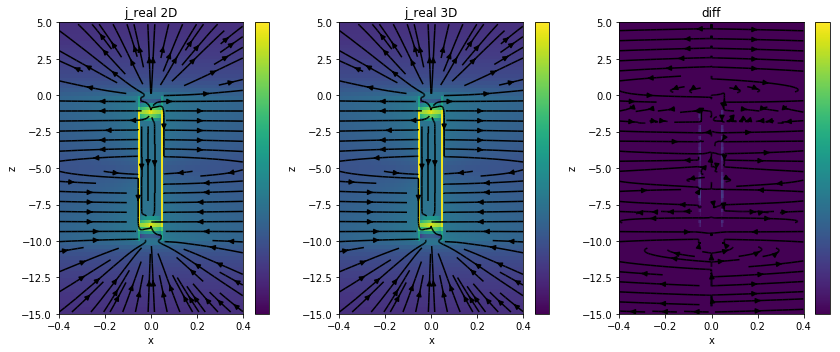

In [22]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
clim = [1e-12, 1e-2]

plotme(j3Dplt.real, ax[0], clim)
plotme(j2D.real, ax[1], clim)
plotme((j3Dplt-j2D).real, ax[2], clim)

ax[0].set_title('j_real 2D')
ax[1].set_title('j_real 3D')
ax[2].set_title('diff')


plt.tight_layout()

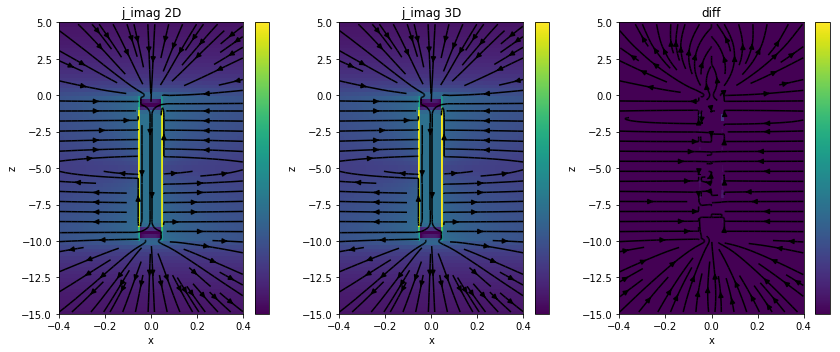

In [23]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
clim = [1e-14, 1e-5]

plotme(j3Dplt.imag, ax[0], clim)
plotme(j2D.imag, ax[1], clim)
plotme((j3Dplt-j2D).imag, ax[2], clim)

ax[0].set_title('j_imag 2D')
ax[1].set_title('j_imag 3D')
ax[2].set_title('diff')


plt.tight_layout()

In [24]:
def normalized_error(val1, val2):
    return np.linalg.norm(val1 - val2) / np.linalg.norm(0.5*(val1+val2))

In [27]:
assert normalized_error(j3Dplt.real, j2D.real) < 1e-7
assert normalized_error(j3Dplt.imag, j2D.imag) < 1e-7